In [3]:
import pandas as pd
import numpy as np

import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt
from matplotlib import gridspec

from numpy import dot, array, zeros, linspace, mod, sqrt, mean, std, exp, sin, cos, arctan, pi, imag, real, angle, mod
from numpy.linalg import norm

import scipy.stats as st
from operator import add

In [4]:
from gensim.models import Word2Vec, KeyedVectors
model = KeyedVectors.load_word2vec_format('/home/surov/Yandex.Disk/research/calculus/123_data/word2vec/GoogleNews-vectors-negative300.bin', binary=True)

/home/surov/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Computing functions

In [5]:
def f1n(s6):
    # Takes: list of strings containing space-separated words for each prototype
    # Returns:
    # stList: list of lists containing words for individual words in each string of s6
    # stVoc: flattened version of stList
    # bnd: boundaries of prototypes in stVoc
    # stvs: mean-normalized Word2Vec vectors for words in stVoc
    # stvm: mean Word2Vec vectors for each prototype
    
    N = len(s6)
    stList = [s.split(' ') for s in s6]
    #print([len(s) for s in stList])
    
    lens = [len(sl) for sl in stList]
    ptr,bnd = 0,[]
    for i in range(N):
        bnd.append([ptr, ptr+lens[i]])
        ptr+=lens[i]
    
    stVoc = [item for st in stList for item in st]
    mnrm = mean([norm(model[w]) for w in stVoc])
    stvs = array([model[w]/mnrm for w in stVoc])

    stvl = [[model[w]/mnrm for w in st.split(' ')] for st in s6]
    stvm = array([mean(stv, axis=0) for stv in stvl])
    
    return stList,stVoc,stvs,stvm,bnd

def f2az2(stvs, stvm, stvsZ, stvmZ, mode):
    #Input: output of f1n().
    #Finds the process-semantic plane Omega (dc) and evaluation axis (dz) 
    #from process-semantic (stvs, stvm) and evaluation (stvsZ, stvmZ) prototypes 
    #Computes process-semantic (-----) and evaluation (-----z) coordinates in qubit space of 
    #individual words (---S) and mean prototypes (---M) for 
    #process-semantic (crdA) and evaluation (crdZ) prototypes
    
    if mode==3: ind = [1,3,5]
    if mode==6: ind = [0,1,2,3,4,5]
    
    a0=3*pi/2
    angs = array([a0 - pi/3 * i for i in ind])
    mc = exp(1j*angs)
        
    mz = array([1,-1])
    dz = dot(mz, stvmZ)
    dz /= np.linalg.norm(dz)
    
    stvmN = stvm.copy()
    for i in range(len(stvm)):
        v = stvm[i]
        v0 = v - dz * dot(v,dz)
        stvmN[i] = v0 / np.linalg.norm(v0)
    
    dc = dot(mc, stvmN[ind])
    #dcN = real(dc)/norm(real(dc))**2 + 1j * imag(dc)/norm(imag(dc))**2
    #dc /= np.linalg.norm(dc)
    #print(np.linalg.norm(dc))
    
    crdAM = dot(stvm,dc)
    ampN = mean(abs(crdAM[ind]))
    dc /= ampN
    
    crdAM = dot(stvm,dc)
    crdAS = dot(stvs,dc)
    crdAMz = dot(stvmZ,dc)
    crdASz = dot(stvsZ,dc)
    
    dz*=2.5
    crdZM = dot(stvm,dz)
    crdZS = dot(stvs,dz)
    crdZMz = dot(stvmZ,dz)
    crdZSz = dot(stvsZ,dz)
    
    return dc,dz,crdAS,crdAM,crdASz,crdAMz,crdZS,crdZM,crdZSz,crdZMz

def coord(wds,dc,dz):
    #Generates dataframe of words in wds and their coordinates in qubit space
    #Fields in the dataframe df:
    #Amp: complex-valued projection of Word2vec vectors to process-semantic plane Omega (dc)
    #X,Y: real and imaginary components of Amp
    #Z: evaluation obtained by projection of Word2vec vectors to evaluation axis Z (dz)
    #R: modulus of Stokes vector for each word
    
    vcs = []
    for w in wds:
        try: vcs.append(model[w])      
        except: 
            print(w)
    
    vcs  = array(vcs)
    vcs /= mean(norm(vcs,axis=1))
    crds = dot(vcs,array([dc,dz]).transpose())

    df = pd.DataFrame(wds, columns = ['Word'])
    df['Amp'] = crds[:,0]
    df['X'] = real(df['Amp'])
    df['Y'] = imag(df['Amp'])
    df['Z'] = real(crds[:,1])
    
    df['R'] = sqrt(df['X']**2 + df['Y']**2 + df['Z']**2)
    
    return(df)

colors = ['c', 'b', 'm', 'r', 'y', 'g']

## Plotting functions

In [11]:
def fp(axp):
    axp.set_xticks(np.linspace(0,2*pi-pi/6,12))
    axp.set_yticks([0.33,0.67,1])
    axp.set_yticklabels([])
    axp.set_theta_zero_location("S")
    axp.set_theta_direction(-1)
    axp.grid(True,ls='--', lw=1, zorder=2)
    return(0)

def f3add2(ax, df, mode, r, rot, alp, fs):
    #ax.set_aspect(aspect=1)
    #cm = matplotlib.cm.get_cmap('Greys')
    df = df.reset_index(drop=True)
    
    if mode == 'w2v':        
        x, y, z, w = df['X'], df['Y'], df['Z'], list(df['Word'])
        vlmin, vlmax = min(z), max(z)
        
        #print(vlmin, vlmax)
        ax.set_xlabel('X, potency')
        ax.set_ylabel('Y, activity')
        
    if mode == 'epa':
        x, y, z, w = df['P'], df['A'], df['E'], list(df['Word'])
        vl = 2
        ax.set_xlabel('P')
        ax.set_ylabel('A',rotation=0)
    
    ax.scatter(x, y, s=55, c = z+0.1, cmap='Greys_r', vmin=vlmin, vmax=vlmax, zorder=4)    
    for i in range(len(df)):
        ax.text(x[i], y[i], w[i], color='k', zorder=5, fontsize=fs)

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    ang = rot * 180/pi
    f1 = matplotlib.patches.Wedge((0,0), r, 60+ang,  180+ang, color="r", alpha=alp)
    f2 = matplotlib.patches.Wedge((0,0), r, 180+ang, 300+ang, color="b", alpha=alp)
    f3 = matplotlib.patches.Wedge((0,0), r, 300+ang,  60+ang, color="g", alpha=alp)
    for f in [f1,f2,f3]: ax.add_artist(f)
    
    return ax

def f3cRot(ax, stList, crdS, crdM, bnd, ang, mode, fs):
    #ax.set_aspect(aspect=1)
    
    crdM2 = crdM.copy()
    
    rfact = exp(1j*ang)
    for i in range(crdM.shape[0]):
        crdM2[i] *= rfact
    for i in range(crdS.shape[0]):
        crdS[i] *= rfact
    
    if mode==3: ind = [1,3,5]
    if mode==6: ind = [0,1,2,3,4,5]
    
    for i in ind:
        x, y = real(crdS[bnd[i][0]:bnd[i][1]]), imag(crdS[bnd[i][0]:bnd[i][1]])
        ax.scatter(x, y, s=15, c=colors[i], zorder=6)
        for j in range(bnd[i][1]-bnd[i][0]):
            ax.text(x[j], y[j], stList[i][j], color=colors[i], zorder=5,fontsize=fs)
        
        r = (std(x)**2 + std(y)**2)**(1/2)
        circ = plt.Circle((real(crdM2[i]),imag(crdM2[i])), r, color=colors[i], alpha=0.5, zorder=4)
        ax.add_artist(circ)
        cc = plt.Circle((real(crdM2[i]),imag(crdM2[i])), 0.01, color=colors[i], alpha=1, zorder=3)
        ax.add_artist(cc)
        
        ax.plot([0,real(crdM2[i])], [0,imag(crdM2[i])], color=colors[i], lw=2,solid_capstyle='round', zorder=2)

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    return ax


def f3cA(ax, stList, crdS, crdM, bnd, fs):
    #ax.set_aspect(aspect=1)
    colors = ['gray','black']
    
    for i in [0,1]:
        x, y = real(crdS[bnd[i][0]:bnd[i][1]]), imag(crdS[bnd[i][0]:bnd[i][1]])
        ax.scatter(x, y, s=15, c=colors[i], zorder=6)
        for j in range(bnd[i][1]-bnd[i][0]):
            ax.text(x[j], y[j], stList[i][j], color=colors[i], zorder=5,fontsize=fs)
        
        r = (std(x)**2 + std(y)**2)**(1/2)
        circ = plt.Circle((real(crdM[i]),imag(crdM[i])), r, color=colors[i], alpha=0.5, zorder=4)
        ax.add_artist(circ)
        cc = plt.Circle((real(crdM[i]),imag(crdM[i])), 0.01, color=colors[i], alpha=1, zorder=3)
        ax.add_artist(cc)
        
        ax.plot([0,real(crdM[i])], [0,imag(crdM[i])], color=colors[i], lw=2,solid_capstyle='round', zorder=2)

    ax.set_xlabel('X, potency')
    ax.set_ylabel('Y, activity')

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    xt = linspace(1.5,-1.5,7)
    ax.set_xticks(-xt)
    ax.set_xticklabels(xt)
    
    return ax

## Finding qubit semantic space with 5 prototypes

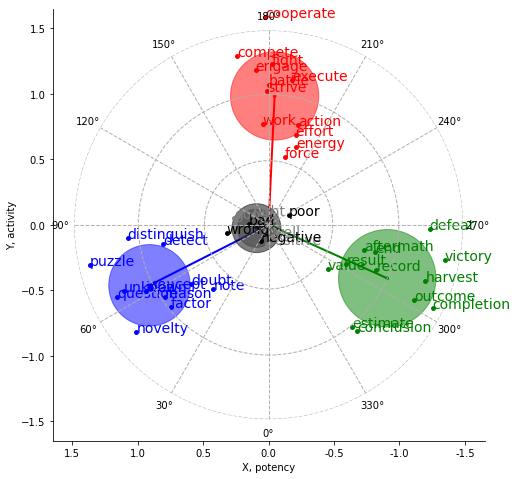

In [7]:
#Three process-semantic prototypes
seed = ['0','concept distinguish factor question unknown puzzle novelty note detect doubt reason idea', 
        '2','action work fight battle force strive compete cooperate execute engage energy effort', 
        '4','end victory defeat result value aftermath estimate record harvest outcome conclusion completion']

#Two evaluation prototypes
goodBad = ['good well right positive', 'bad poor wrong negative']

stList,stVoc,stvs,stvm,bnd = f1n(seed)
stListZ,stVocZ,stvsZ,stvmZ,bndZ = f1n(goodBad)

dc,dz,crdAS,crdAM,crdASz,crdAMz,crdZS,crdZM,crdZSz,crdZMz = f2az2(stvs, stvm, stvsZ, stvmZ, mode=3)

fig = plt.figure(figsize=(6,6))
l, md = 1.65,3
axc = fig.add_axes([0,0,1,1], ylim=(-l,l), xlim=(-l,l), aspect='equal')
axp = fig.add_axes([0.05,0.05,0.9,0.9], polar=True, zorder=1,frameon=False)
fp(axp)
f3cRot(axc, stList, crdAS, crdAM, bnd, ang=0, mode=md, fs=14);
f3cA(axc, stListZ, crdASz, crdAMz, bndZ, fs=14);

In [ ]:
# Angular scattering within process-semantic prototypes
s1 = std(angle(crdAS[1:13]))
s2 = std(angle(crdAS[14:26]))
s3 = std(angle(crdAS[27:39]))
mean([s1,s2,s3]) * 180/pi

## Mapping of emotion-related words

In [8]:
emall = ['surprised', 'amazed', 'curious', 'curiosity', 'surprise','fortitude', 'tenacity', 'courage', 'courageous', 
         'brave', 'devotion', 'amused', 'zeal', 'ardor', 'euphoric', 'euphoria',
         'fear','afraid','scared','confused','confusion','boredom',
         'anger','angry','rage','wrath','malice','hate','hatred','disappointment',
         'ecstasy', 'bliss', 'eager', 'inspire', 'aspire', 'alert', 'spirited', 'proud', 'excited', 'ingenious', 
         'energetic', 'astonished', 'agile', 'passion', 'love', 'loving','joy', 'happiness', 'serenity',
         'alarmed', 'ambitious', 'ambition', 'longing', 'panic', 'disappointed', 'upset', 'dread', 
         'contempt', 'dismay', 'embarrassed', 'disgust', 'agitated', 'lethargic', 'sorrow', 
         'guilt', 'melancholy', 'agony', 'shame', 'worried', 'worry', 'thrill', 'anxiety',
         'sadness', 'grief', 'despair','interested','nervous','bravery','zest','interest','willing',
        'jubilation','rapture','contentment','acceptance','humiliation','dejection','nervousness','depression',
        'elation','misery','enthusiasm','enthusiastic','vigilance','alertness','hostility','respect','honor']
print(len(emall))

98


In [9]:
# Data to plot
emr = coord(emall,dc,dz)
emr

,Word,Amp,X,Y,Z,R
0,surprised,-0.287925-0.198269j,-0.287925,-0.198269,-0.108356,0.365995
1,amazed,-0.541161-0.083990j,-0.541161,-0.083990,0.116969,0.559993
2,curious,-0.803984-0.381637j,-0.803984,-0.381637,-0.056857,0.891779
3,curiosity,-0.779690-0.302301j,-0.779690,-0.302301,0.018233,0.836442
4,surprise,-0.264646-0.431431j,-0.264646,-0.431431,-0.079040,0.512267
...,...,...,...,...,...,...
93,vigilance,-0.213179+0.355406j,-0.213179,0.355406,0.245552,0.481720
94,alertness,-0.173554+0.236016j,-0.173554,0.236016,0.118404,0.315981
95,hostility,-0.038825+0.167379j,-0.038825,0.167379,-0.447602,0.479449
96,respect,0.025825+0.318617j,0.025825,0.318617,0.189563,0.371642


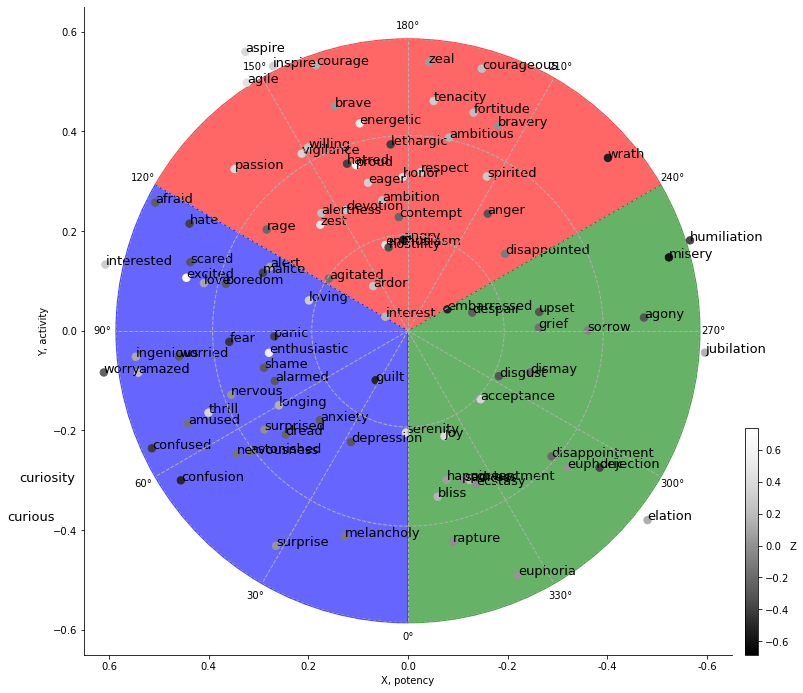

In [12]:
fig = plt.figure(figsize=(9,9))
l=0.65
axc2 = fig.add_axes([0,0,1,1], ylim=(-l,l), xlim=(-l,l), aspect='equal')
axp2 = fig.add_axes([0.05,0.05,0.9,0.9], polar=True, zorder=1,frameon=False)
fp(axp2)

f3add2(axc2,emr,mode='w2v',r=0.586,rot=-pi/6,alp=.6,fs=13);

mpb = axc2.collections[0]
cax = fig.add_axes([1.02,0,0.02,0.35])
cb = fig.colorbar(mpb, cax=cax, shrink=0.1)
cax.set_ylabel('Z', rotation=0);

xt = array([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
axc2.set_xticks(-xt)
axc2.set_xticklabels(xt);